In [1]:
import requests
import json
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from os import path

In [22]:
def datamuse(query):
    # http://www.datamuse.com/api/
    url = "https://api.datamuse.com/words?ml=" + query + "&max=75" #max = number of results to return
    response = requests.get(url)
    similar_words = [x['word'] for x in json.loads(response.content)]
    return similar_words

In [23]:
def mc28():
    with open('datasets/sim-eval-master/datasets/mc.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        rows = []
        for row in reader: rows.append(row)
        return rows # [[word1, word2, similarity], ...] 
    
def load_dataset(name):
    with open('datasets/sim-eval-master/datasets/{name}.csv'.format(name=name), newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        rows = []
        for row in reader: rows.append(row)
        return rows # [[word1, word2, similarity], ...] 

# SN is classification data




[['alligator', 'aggressive', 'attri'],
 ['alligator', 'aquatic', 'attri'],
 ['alligator', 'big', 'attri'],
 ['alligator', 'carnivorous', 'attri'],
 ['alligator', 'dangerous', 'attri'],
 ['alligator', 'ferocious', 'attri'],
 ['alligator', 'frightening', 'attri'],
 ['alligator', 'green', 'attri'],
 ['alligator', 'heavy', 'attri'],
 ['alligator', 'hungry', 'attri'],
 ['alligator', 'large', 'attri'],
 ['alligator', 'long', 'attri'],
 ['alligator', 'old', 'attri'],
 ['alligator', 'scary', 'attri'],
 ['alligator', 'wild', 'attri'],
 ['alligator', 'young', 'attri'],
 ['alligator', 'crocodile', 'coord'],
 ['alligator', 'frog', 'coord'],
 ['alligator', 'lizard', 'coord'],
 ['alligator', 'snake', 'coord'],
 ['alligator', 'toad', 'coord'],
 ['alligator', 'turtle', 'coord'],
 ['alligator', 'attack', 'event'],
 ['alligator', 'bask', 'event'],
 ['alligator', 'breathe', 'event'],
 ['alligator', 'chase', 'event'],
 ['alligator', 'die', 'event'],
 ['alligator', 'drink', 'event'],
 ['alligator', 'eat', 

In [24]:
def stss131():
    # https://www.researchgate.net/publication/262411640_A_new_benchmark_dataset_with_production_methodology_for_short_text_semantic_similarity_algorithms
    with open('datasets/stss-131/stss.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        rows = []
        for row in reader: rows.append(row)
        return rows # [[index, sentence1, sentence2, avg similarity, standard deviation], ...]

In [25]:
def jaccard(word_list1, word_list2):
    intersection = len(set(word_list1).intersection(word_list2))
    union = len(set(word_list1).union(word_list2))
    jaccard_similarity = intersection / union
    return jaccard_similarity

In [157]:
from functools import reduce, partial
from itertools import starmap

def get_ml(w,c):
    """ Get a function for querying the related words """
    return [lambda: datamuse(
       "{word}&max={count}"
       .format(word=w,count=c)
    ), w]

def relations_to_file(fn, word):
    """
    fn: query function
    word
    """
    filename = "./related-words/{}.ml".format(word)
        
    with open(filename, 'w') as f:
        """ 
        Query the related words one at a time 
        when required for writing to file 
        """
        for word in fn():
            f.write(word)
            f.write('\n')
            
    return filename

def collect_ml_getters(dataset_fn, count=100):
    """ Collect the getters for lazy evaluation """
    return reduce(lambda acc, fns: acc + fns, [
        [get_ml(f,count), get_ml(s,count)]
        for f, s, _ 
        in dataset_fn()
    ], [])

def get_and_write_dataset_words_to_files(dataset_fn, count=30):
    """works for files that return tuple with three items per row"""
    return list(starmap(
        relations_to_file, 
        collect_ml_getters(dataset_fn, count)
    ))

# write the files with
# get_and_write_dataset_words_to_files(mc28, count=100)




In [76]:
wordsim = lambda: load_dataset('wordsim')
debug_val = collect_ml_getters(wordsim, count=1)


In [85]:
def plussaa(accumulator, variable):
    print(accumulator)
    print(variable)
    return accumulator + variable

reduce(
    # functio (accumulator, iterator)
    plussaa, 
    # iterator take a valua one at a time
    ["h","e","i"],
    # Accumulator for the first round
    ""
)


h
h
e
he
i


'hei'

Text(0, 0.5, 'Correlation')

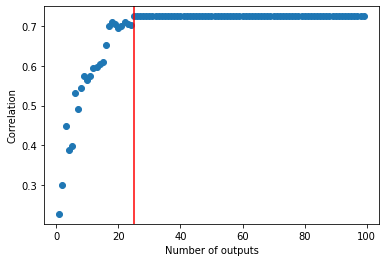

In [152]:
# We would like to test the similarity between the pair (X,Y) by using the output of the Datamuse API 
# for both X and Y. Set the number of outcome words in the API to be large, e.g., 30. Use Jaccard similarity 
# to compute the similarity between X and Y (Counting the ratio of common words among the outputs of X and Y 
# Datamuse API over the total number of distinct words in the two outputs).
#
# Repeat this process of calculating the similarity between each pair in MC-28 dataset, and then calculate the
# correlation coefficient with the human judgment using Pearson coefficient. 
# Try to optimize the parameters ofd atamuse API call by testing distinct number of outputs and monitor the 
# value of the correlation until you reach
# the highest correlation value. 

mc = np.array(mc28())


def load_from_file(word):
    with open('./related-words/'+word+'.ml', 'r') as f:
        return np.array([ l.replace("\n", "") for l in f])        

def calc_correlation(data):
    def f(number_of_outputs):
        get_rel_words = lambda word: load_from_file(word)

        similarity = lambda row: jaccard(
            get_rel_words(row[0])[:number_of_outputs], 
            get_rel_words(row[1])[:number_of_outputs]
        )

        datamuse_similarity = np.apply_along_axis(similarity, 1, data)
        ground_truth = data.transpose()[2].astype(np.float)
        return pearsonr(datamuse_similarity, ground_truth)[0]
    
    return f


n = np.arange(1, 100, 1)

corr = np.vectorize(calc_correlation(mc))(n)

plt.scatter(n, corr)
plt.axvline(x=n[np.argmax(corr)], color="red")
plt.xlabel("Number of outputs")
plt.ylabel("Correlation")

# Use this configuration to calculate the correlation value for other datasets, and 
# compare the result with other state-of-art results as reported in relevant literature (e.g., previous sim-eval 
# repository) .

In [141]:
wordsim = load_dataset('wordsim')

uniq_wordsim = set(reduce(lambda x,y: x + y, [ [a,b] for a,b,x in wordsim ], []))
collected_getters = [get_ml(w, 25) for w in list(uniq_wordsim)]

In [144]:
def load_unique_words_to_file(name):
    uniq_wordsim = set(reduce(lambda x,y: x + y, [ [a,b] for a,b,x in load_dataset(name) ], []))
    collected_getters = [get_ml(w, 25) for w in list(uniq_wordsim)]
    list(starmap(relations_to_file, collected_getters))

In [145]:
load_unique_words_to_file('rg')

Text(0, 0.5, 'Correlation')

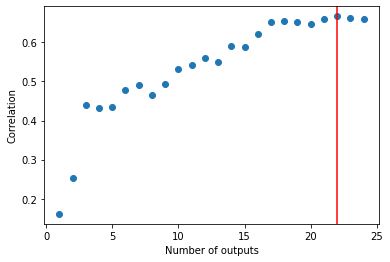

In [154]:
n = np.arange(1, 25, 1)

corr = np.vectorize(calc_correlation(np.array(load_dataset('rg'))))(n)

plt.scatter(n, corr)
plt.axvline(x=n[np.argmax(corr)], color="red")
plt.xlabel("Number of outputs")
plt.ylabel("Correlation")
